In [2]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

In [26]:
serias_dj = pd.read_csv("weekly-closings-of-the-dowjones-.csv")["Close"]
serias_FB = pd.read_csv("daily-total-female-births-in-cal.csv")["Count"]
serias_sc = pd.read_csv('monthly-sales-of-company-x-jan-6.csv')["Count"]
serias_rb = pd.read_csv('monthly-boston-armed-robberies-j.csv')["Count"]
serias_mt = pd.read_csv("mean-monthly-air-temperature-deg.csv")["Deg"]

Построим модель для окна 2 элемента

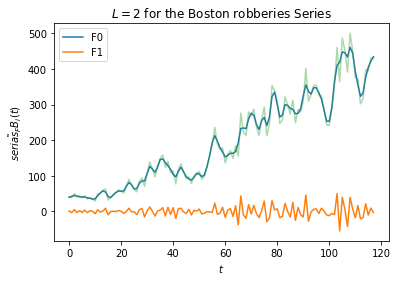

In [62]:
ssa_L2 = SSA(serias_rb, 2)
ssa_L2.components_to_df().plot()
ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{serias_FB}_i(t)$")
plt.title(r"$L=2$ for the Boston robberies Series");

Теперь попробуем сделать окно в 5 элементов

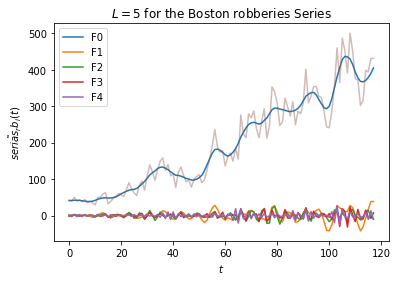

In [65]:
ssa_L5 = SSA(serias_rb, 5)
ssa_L5.components_to_df().plot()
ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{serias_rb}_i(t)$")
plt.title(r"$L=5$ for the Boston robberies Series");

Попробуем выделить отдельно тренд и остальные составляющие

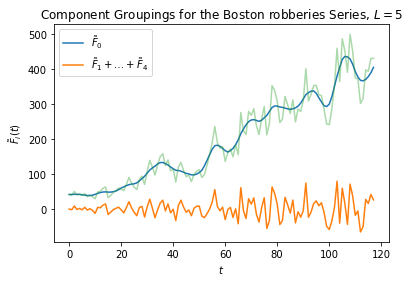

In [75]:
ssa_L5.reconstruct([0]).plot()
#ssa_L5.reconstruct([1]).plot()
ssa_L5.reconstruct(slice(1,5)).plot()
ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for the Boston robberies Series, $L=5$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+ \ldots + \tilde{F}_{4}$"]);

Рассмотрим матрицу корреляции

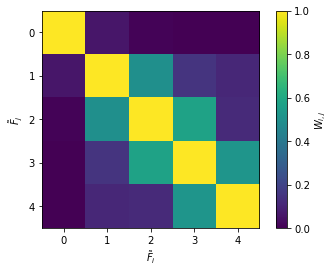

In [61]:
ssa_L5.plot_wcorr()

объединим первые две компоненты и оставшиеся остальные.
Теперь тренд стал лучше описывать исходный ряд

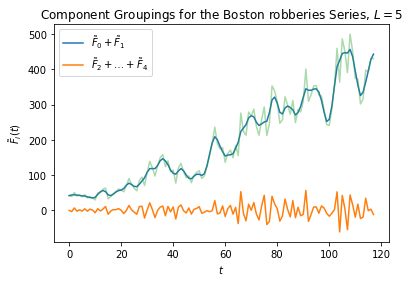

In [74]:
#DJ_ssa_L2.reconstruct(0).plot()
ssa_L5.reconstruct([0,1]).plot()
ssa_L5.reconstruct(slice(2,5)).plot()
ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for the Boston robberies Series, $L=5$");
plt.legend([r"$\tilde{F}_0+\tilde{F}_1$", 
            r"$\tilde{F}_2+ \ldots + \tilde{F}_{4}$"]);

Сделаем окно в 10 элементов

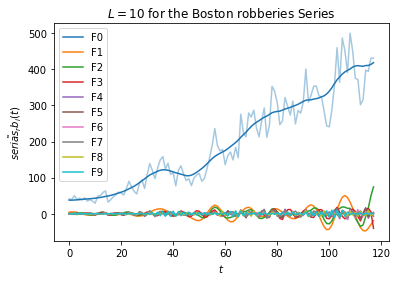

In [77]:
ssa_L10 = SSA(serias_rb, 10)
ssa_L10.components_to_df().plot()
ssa_L10.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{serias_rb}_i(t)$")
plt.title(r"$L=10$ for the Boston robberies Series");

Рассмотрим матрицу корреляции

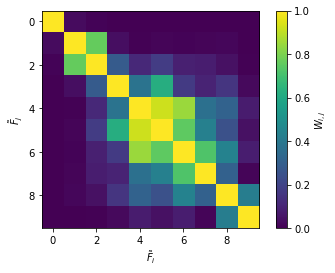

In [78]:
ssa_L10.plot_wcorr()

Выделим нулевую компоненту, объединим 1-ю и 2-ю, а также все остальные выделим в отдельный шум

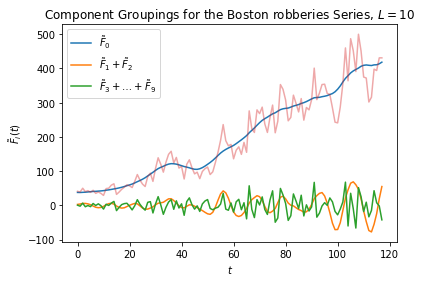

In [81]:
ssa_L10.reconstruct(0).plot()
ssa_L10.reconstruct([1,2]).plot()
ssa_L10.reconstruct(slice(3,10)).plot()
ssa_L10.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for the Boston robberies Series, $L=10$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2$", 
            r"$\tilde{F}_3+ \ldots + \tilde{F}_{9}$"]);

Сделаем окно в 20 элементов

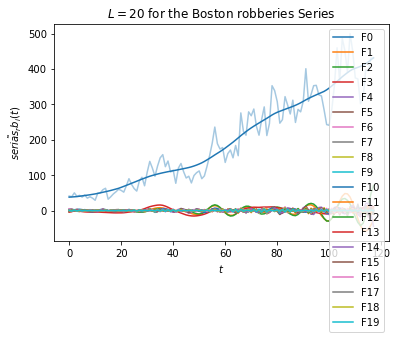

In [82]:
ssa_L20 = SSA(serias_rb, 20)
ssa_L20.components_to_df().plot()
ssa_L20.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{serias_rb}_i(t)$")
plt.title(r"$L=20$ for the Boston robberies Series");

Рассмотрим матрицу корреляции

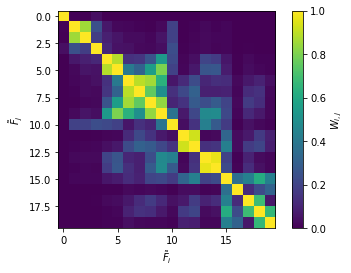

In [83]:
ssa_L20.plot_wcorr()

рассмотрим матрицу корреляции первых 10 компонент

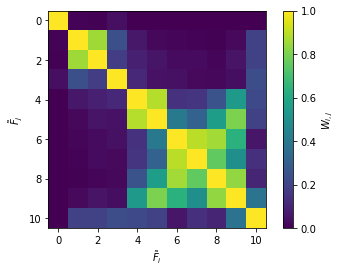

In [84]:
ssa_L20.plot_wcorr(max=10)

Сделаем 3 новые компоненты из 20-ти: 0-ю оставим без изменений в качестве тренда, объединим 1, 2, 3-ю, а с 4-й и до конца объединим в шум

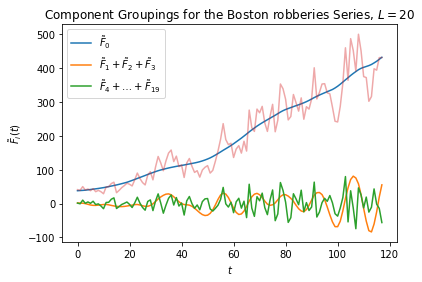

In [95]:
ssa_L20.reconstruct(0).plot()
ssa_L20.reconstruct([1,2,3]).plot()
ssa_L20.reconstruct(slice(4,20)).plot()
ssa_L20.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for the Boston robberies Series, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$"]);

Рассмотрим окно в 50 элементов

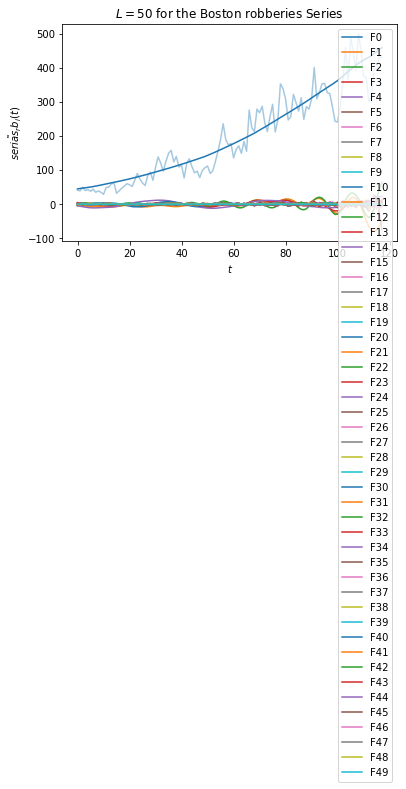

In [87]:
ssa_L50 = SSA(serias_rb, 50)
ssa_L50.components_to_df().plot()
ssa_L50.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{serias_rb}_i(t)$")
plt.title(r"$L=50$ for the Boston robberies Series");

Рассмотрим матрицы корреляции

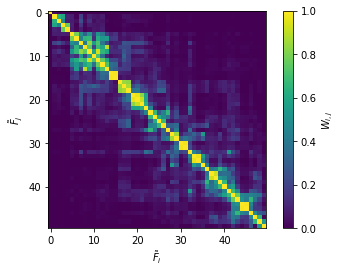

In [88]:
ssa_L50.plot_wcorr()

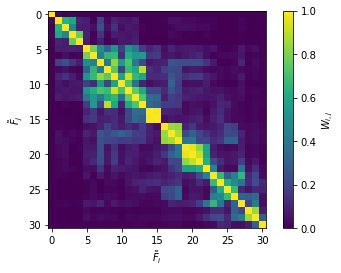

In [90]:
ssa_L50.plot_wcorr(max=30)

Сделаем 3 новые компоненты из 50-ти: 0-ю оставим без изменений в качестве тренда, объединим 1, 2, 3, 4-ю, с 5-й по 13-ю тоже объединим в новую компоненты, а с 14-й и до конца объединим в шум

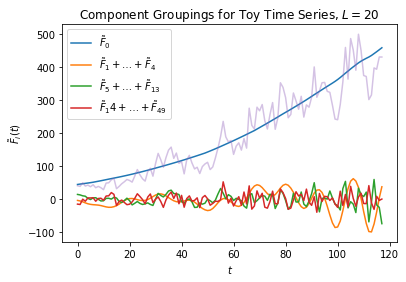

In [94]:
ssa_L50.reconstruct(0).plot()
ssa_L50.reconstruct([1,2,3,4]).plot()
ssa_L50.reconstruct(slice(5,13)).plot()
ssa_L50.reconstruct(slice(14,50)).plot()
ssa_L20.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for the Boston robberies Series, $L=50$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+ \ldots +\tilde{F}_4$", 
            r"$\tilde{F}_5+ \ldots + \tilde{F}_{13}$",
            r"$\tilde{F}_14+ \ldots + \tilde{F}_{49}$"]);